# Exploring Hugging Face Accelerate with `xaitk-saliency` Integration

This example explores integrating `xaitk-saliency` and Hugging Face Accelerate with multi-GPU based inference.

## Table of Contents

* [Environment Setup](#environment-setup)
* [Imports](#imports)
* [`xaitk-saliency` Integration](#xaitk-integration)
  * [Defining the "Application"](#defining-the-application)
  * [Black-Box Classifer](#black-box-classifier)
  * [Saliency Generator](#saliency-generator)
  * [Generate Saliency Maps](#generate-saliency-maps)
  * [Results Comparison](#results-comparison)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/xaitk-jatic/blob/main/docs/examples/huggingface/xaitk-accelerate.ipynb)

## Environment Setup <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/xaitk-jatic/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

**Running huggingface in Colab requires an API key. Log in to https://huggingface.co/, generate an access token, then add that token to Colab using the key icon in the left menu.**

In [1]:
import sys  # noqa:F401

!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q xaitk-jatic
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing smqtk-classifier...")
!{sys.executable} -m pip install -qU smqtk-classifier
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -qU datasets fsspec huggingface_hub
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing Hugging Face accelerate...")
!{sys.executable} -m pip install -q accelerate
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Done!")

Installing xaitk-jatic...
Installing xaitk-saliency...
Installing smqtk-classifier...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing Hugging Face accelerate...
Installing torch...
Installing torchvision...
Installing matplotlib...
Done!


In [2]:
# Note PREDICT_SIZE should be >= BATCH_SIZE, due to the way Accelerate distributes data
BATCH_SIZE = 1
PREDICT_SIZE = 2
MASKED_DATA_BATCH_SIZE = 128
NUM_PROCESSES = 1

## Imports <a name="imports"></a>

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore

# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

# For "artifact tracking" (to compare results)
import pickle
from collections.abc import Iterable, Iterator
from pathlib import Path
from typing import Any

import numpy as np
import torch  # type: ignore
from accelerate import Accelerator, DataLoaderConfiguration, notebook_launcher  # type: ignore
from accelerate.utils import set_seed  # type: ignore
from datasets import load_dataset  # type: ignore
from scipy.special import softmax
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from torch.utils.data import DataLoader, Dataset, IterableDataset  # type: ignore
from torchvision import transforms  # type: ignore
from transformers import AutoModelForImageClassification  # type: ignore
from typing_extensions import override
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency

## `xaitk-saliency` Integration <a name="xaitk-integration"></a>

### Defining the "Application" <a name="defining-the-application"></a>

To use Hugging Face Accelerate within a notebook, we must be careful to avoid initializing CUDA as it can only be initialized once. We'll wrap all our main functionality in a function that we'll call via `notebook_launcher` to avoid this.

In [4]:
def app(  # noqa:C901
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    use_accelerate: bool = True,
    display_results: bool = False,
    results_filepath: str | None = None,
) -> None:
    """
    Generates saliency maps for a subset of the CIFAR10 dataset using a Hugging Face model.

    Args:
        saliency_generator (GenerateImageClassifierBlackboxSaliency):
            A saliency map generator that uses black-box image classifiers.
        use_accelerate (bool, optional):
            Whether to use Hugging Face Accelerate for model and data parallelism. Defaults to True.
        display_results (bool, optional):
            Whether to display the generated saliency maps. Defaults to False.
        results_filepath (Optional[str], optional):
            Path to save the gathered saliency maps. If None, results are not saved. Defaults to None.

    Returns:
        None: The function generates and optionally displays or saves saliency maps.
    """

    class TestDataset(Dataset):
        """
        A dataset for testing image classification and saliency map generation.

        Attributes:
            data (list[np.ndarray]): List of input images.
            transform (transforms.Compose): Transformation pipeline applied to images.
        """

        def __init__(self, data: list[np.ndarray]) -> None:
            """
            Initializes the TestDataset with the input data.

            Args:
                data (list[np.ndarray]): List of input images.
            """
            self.data = data
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    transforms.Resize((224, 224), antialias=True),  # type: ignore
                ],
            )

        def __getitem__(self, index: int) -> torch.Tensor:
            """
            Retrieves an image and applies transformations.

            Args:
                index (int): Index of the image to retrieve.

            Returns:
                torch.Tensor: Transformed image tensor.
            """
            output = self.transform(self.data[index])
            if not isinstance(output, torch.Tensor):
                raise ValueError("Transformation must return a torch.Tensor object")
            return output

        def __len__(self) -> int:
            """
            Returns the total number of images.

            Returns:
                int: Number of images in the dataset.
            """
            return len(self.data)

    accelerator = None
    if use_accelerate:
        # For reproducability
        set_seed(42)

        # Set up the accelerator
        dataloader_config = DataLoaderConfiguration(even_batches=True)
        accelerator = Accelerator(dataloader_config=dataloader_config)

    # Get the model
    model_name = "aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"
    model = AutoModelForImageClassification.from_pretrained(model_name)

    # Predicting on a subset of the CIFAR10 Test dataset
    ds = load_dataset("cifar10", split="test")
    labels = ds.features["label"].names  # type: ignore
    num_classes = len(labels)
    ds_shuffle = ds.shuffle(seed=42)
    images = ds_shuffle[0:PREDICT_SIZE]["img"]  # type: ignore
    dataloader = DataLoader(TestDataset(images), batch_size=min(BATCH_SIZE, PREDICT_SIZE))

    if accelerator:
        # Prepare the model and dataloader for use with accelerate
        model, dataloader = accelerator.prepare(model, dataloader)

    image_classifier = AccelerateClassifier(model, labels, accelerator, transform=None)

    # Generate saliency maps
    sal_maps_set = []
    for batch in dataloader:
        b = batch.cpu().data.numpy()
        for img in b:
            sal_maps = saliency_generator(np.moveaxis(img, 0, -1), image_classifier)
            sal_maps_set.append(sal_maps)

    # Gather results from across devices
    if accelerator:
        accelerator.wait_for_everyone()
        t_sal_maps_set = torch.Tensor(np.array(sal_maps_set)).to(accelerator.device)
        sal_maps_set_gathered = accelerator.gather(t_sal_maps_set)
        sal_maps_set_gathered = torch.Tensor(sal_maps_set_gathered).data.cpu().numpy()
    else:
        sal_maps_set_gathered = sal_maps_set

    # Plot each image in set with saliency maps
    if display_results and (accelerator is None or accelerator.is_main_process):
        for i in range(len(images)):
            plt.figure(figsize=(10, 5))
            num_cols = np.ceil(num_classes / 2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow(images[i], cmap="gray")
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set_gathered[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")
            for c in range(num_classes - num_cols + 1, num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set_gathered[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")

    # Save results for comparison for examples sake
    if results_filepath is not None and (accelerator is None or accelerator.is_main_process):
        with open(results_filepath, "wb") as file:
            pickle.dump(sal_maps_set_gathered, file)

### Black-Box Classifier <a name="black-box-classifier"></a>

To use the selected model with the `GenerateImageClassifierBlackboxSaliency` interface, we need to create an implementation of `ClassifyImage` that wraps the underlying model. The core method that requires implementation is `classify_images()` which takes images and returns predictions for each image in the format defined by the interface.

We'll also define an `IterableDataset` to operate on the masked dataset in batches.

In [5]:
class AccelerateClassifier(ClassifyImage):
    """
    A classifier that uses a PyTorch model accelerated with the Hugging Face Accelerate library
    for image classification tasks.

    Attributes:
        model (torch.nn.Module): The PyTorch model used for inference.
        labels (list): List of class labels.
        accelerator (Optional[Accelerator]): The Hugging Face Accelerate object for device management.
        transform (Optional[transforms.Compose]): Transformations applied to input images.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        labels: list,
        accelerator: Accelerator | None = None,
        transform: transforms.transforms.Compose | None = None,
    ) -> None:
        """
        Initializes the AccelerateClassifier.

        Args:
            model (torch.nn.Module): A PyTorch model for classification.
            labels (List[str]): List of class labels.
            accelerator (Optional[Accelerator]): An optional Hugging Face Accelerator for device management.
            transform (Optional[transforms.Compose]): Optional transformations for preprocessing input images.
        """
        self.model = model
        self.accelerator = accelerator
        self.labels = labels
        self.transform = transform

    @override
    def get_labels(self) -> list[str]:
        return self.labels

    class ClassifyImagesDataset(IterableDataset):
        """
        An iterable dataset that processes a stream of images for classification.

        Attributes:
            iterable (Iterable[np.ndarray]): Iterable of input images as NumPy arrays.
            device (Optional[str]): Target device for tensor processing (e.g., 'cpu', 'cuda').
            transform (Optional[transforms.Compose]): Transformations applied to input images.
        """

        def __init__(
            self,
            iterable: Iterable[np.ndarray],
            device: str | None = None,
            transform: transforms.transforms.Compose | None = None,
        ) -> None:
            """
            Initializes the ClassifyImagesDataset.

            Args:
                iterable (Iterable[np.ndarray]): Iterable of input images.
                device (Optional[str]): Device to which tensors will be moved.
                transform (Optional[transforms.Compose]): Optional transformations for preprocessing.
            """
            self._iterable = iterable
            self._device = device
            self._transform = transform

        def __iter__(self) -> Iterator[torch.Tensor | Any]:
            """
            Processes images by applying transformations and moving tensors to the appropriate device.

            Yields:
                torch.Tensor: Preprocessed image tensors ready for inference.
            """
            tnsfm = self._transform
            device = self._device

            for image in self._iterable:
                image = np.moveaxis(image, -1, 0)
                item = tnsfm(image) if tnsfm else image
                if device:
                    item = torch.Tensor(item).to(device)
                yield item

    @override
    def classify_images(self, img_iter: Iterable[np.ndarray]) -> Iterator[dict[str, float]]:
        dataloader = DataLoader(
            self.ClassifyImagesDataset(img_iter, self.accelerator.device if self.accelerator else None),
            batch_size=MASKED_DATA_BATCH_SIZE,
            shuffle=False,
        )

        self.model.eval()
        results = []
        for batch in dataloader:
            with torch.no_grad():
                preds = softmax(self.model(batch).logits.data.cpu().numpy(), axis=1)
            results.extend([{la: p for p, la in zip(pred, self.labels, strict=False)} for pred in preds])

        return iter(results)

    # Required for implementation
    @override
    def get_config(self) -> dict[str, Any]:
        return {}

### Saliency Generator <a name="saliency-generator"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image pertubation and heatmap generation. 

The images will already be normalized when the saliency generator gets the image, so we don't need to set a fill value here.

In [6]:
gen_sliding_window = SlidingWindowStack(window_size=(14, 14), stride=(7, 7), threads=4)

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

We can now use the `notebook_launcher` interface to carry out our distributed saliency map generation. [Accelerate documentation](https://huggingface.co/docs/accelerate/v0.11.0/en/launcher) has more information about the notebook launcher.

Launching training on one GPU.


/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


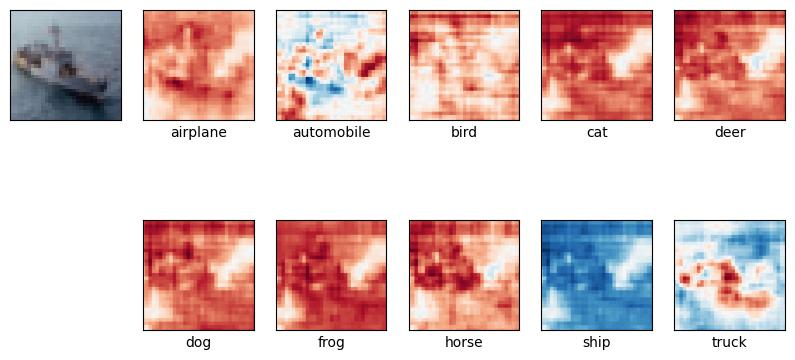

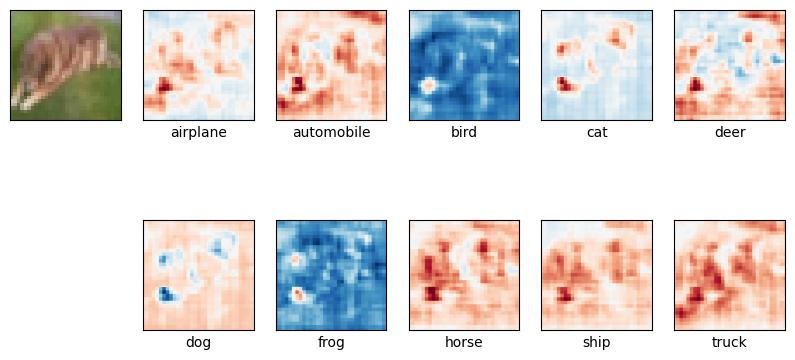

In [7]:
args = (
    gen_sliding_window,
    True,  # use_accelerate
    True,  # display_results
    "with_accelerate.pkl",  # results_filepath
)
notebook_launcher(app, args, num_processes=NUM_PROCESSES)

We'll also generate saliency maps without Accelerate, to confirm results are the same with/without scaling:

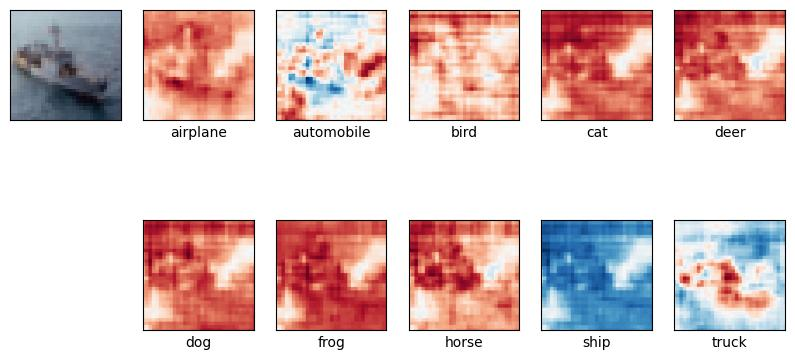

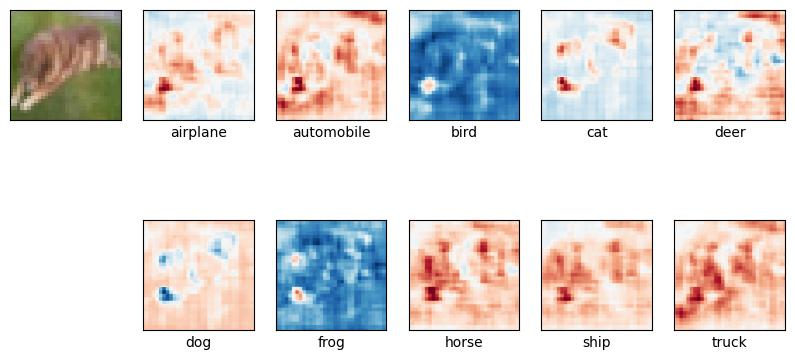

In [9]:
app(
    gen_sliding_window,
    use_accelerate=False,
    display_results=True,
    results_filepath="wo_accelerate.pkl",
)

### Results Comparison <a name="results-comparison"></a>

We can see, via visual inspection, that the saliency maps produced are consistent across both methods, as expected. We can also confirm this numerically:

In [10]:
def safe_load_pickle(file_path: str) -> list[np.ndarray] | Any:  # noqa:ANN401
    """
    Safely loads a pickle file using a context manager.

    Args:
        file_path (str): Path to the pickle file.

    Returns:
        Any: Deserialized data from the pickle file.

    Raises:
        FileNotFoundError: If the file does not exist.
        RuntimeError: If deserialization fails due to a pickle or I/O error.
    """
    if not Path(file_path).is_file():
        raise FileNotFoundError(f"File not found: {file_path}")

    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)  # noqa:S301
            data = [np.array(el) for el in data]
            if not isinstance(data, list) or not all(isinstance(x, np.ndarray) for x in data):
                raise RuntimeError("Deserialized data is not a list of np.ndarray.")
            return data
    except (pickle.PickleError, OSError):
        print(f"Failed to load pickle file '{file_path}'")


# Load data safely
with_accelerate = safe_load_pickle("with_accelerate.pkl")
wo_accelerate = safe_load_pickle("wo_accelerate.pkl")

# Perform comparison or checks
allclose = [True] * len(with_accelerate)
for idx, compare in enumerate(zip(with_accelerate, wo_accelerate, strict=False)):
    for w, wo in zip(compare[0], compare[1], strict=False):
        # Normalize data
        w = (w - np.min(w)) / (np.max(w) - np.min(w))
        wo = (wo - np.min(wo)) / (np.max(wo) - np.min(wo))

        if not np.allclose(w, wo, atol=1e-02):
            allclose[idx] = False
            break
print(allclose)
if not all(allclose):
    raise ValueError("allclose must be all True")

[True, True]
